# 6 - Application of Supervised Learning

## Dataset - "House Prices - Advanced Regression Techniques" from Kaggle

For this part of the project, we have chosen to work on the Kaggle competition dataset "House Prices - Advanced Regression Techniques".

The dataset contains 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa. The of the competition was to predict the final price of a given home specifications / features.

The dataset can be found here: [House prices - Advanced Regression Techniques](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data)

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from optuna.samplers import TPESampler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from xgboost import XGBRegressor

from sklearn.metrics import accuracy_score, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.impute import SimpleImputer

## Data loading

We first need to load the training data and testing data from the dataset.

In [2]:
training_data = pd.read_csv('./house-prices/train.csv')
testing_data = pd.read_csv('./house-prices/test.csv')

## Data visualization

### House prices

In order to have an idea of the distribution of the house prices, we can plot a histogram.

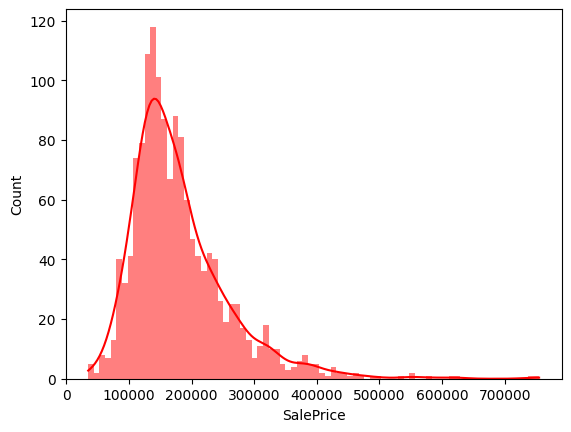

In [3]:
_ = sns.histplot(training_data['SalePrice'], color='r', bins=80, alpha=0.5, edgecolor=None, kde=True)

We can observe that the distribution is not normal, and is skewed to the right. Concretely, there are a majority of low priced houses, and a small minority of houses with a high price.<br>
That needs to be taken into consideration, as it may represent a bias for a model while learning features.

### Features

## Preprocessing

As we are using raw data, we need to clean it through preprocessing, in order to make it usable, and as reliable as possible for the training phase.<br>
The preprocessing phase will be composed of the following steps:
* Removing columns composed of categorical data, as the scikit-learn library does not support this type of data.
* Removing columns with a high percentage of missing values. For that, we will use a default threshold of 50%. However, it would be interesting to test different thresholds, to see which impact it has on the final results.
* Removing columns with a lot of identical values, as they will not be useful for the training phase. Indeed, they will not bring any interesting features for the model to learn.
* Filling the missing values with data imputation. The policy we will use is to fill the missing values with the mean of the column. That should be the least altering method, as it will not create any outliers, and will not change the distribution of the data.

In [4]:
def preprocess(data: pd.DataFrame, threshold: float = 0.5, imputation_policy: str = 'mean') -> pd.DataFrame:
    """
    Preprocess data:
    - Drop columns that have categorical values
    - Drop columns that have 50% or more missing values over all rows
    - Fill missing values with the mean strategy

    Args:
        data (pd.DataFrame): Data to preprocess
        threshold (float): Threshold to drop columns that have missing values
        imputation_policy (str): Imputation policy to fill missing values
    Returns:
        pd.DataFrame: Preprocessed data
    """
    # Drop columns containing categorical values
    data = data.drop(data.columns[data.dtypes == 'object'], axis=1)
    
    # Drop columns that have at least half of missing values
    corrupted_columns = data.columns[data.isnull().mean() >= threshold]
    data = data.drop(corrupted_columns, axis=1)

    # Drop columns that have at least half of the same values
    same_value_columns = data.columns[data.nunique() <= 1]
    data = data.drop(same_value_columns, axis=1)

    # Fill missing numerical values with the mean strategy,
    # using data imputation
    imcomplete_columns = data.columns[data.isna().any()]
    simple_imputer = SimpleImputer(strategy=imputation_policy, missing_values=np.nan)
    data[imcomplete_columns] = simple_imputer.fit_transform(data[imcomplete_columns])

    return data

We can now apply preprocessing to our data. For now, we use the default preprocessing parameters.

In [5]:
preprocessed_training_data = preprocess(training_data)
preprocessed_testing_data = preprocess(testing_data)

There is still one last step to go through before training the model. Indeed, we need to split our training data into a training, a validation and a testing set. We will use the following distribution:
* Training - 80%
* Testing - 20%

We use 20% of the data for the testing set, to have a robust estimation of the model's generalization capabilities.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(preprocessed_training_data.drop('SalePrice', axis=1), preprocessed_training_data['SalePrice'], test_size=0.2, random_state=42)

## Regression

### Models

Our goal is to predict the price of a house, based on its features. Therefore, we will use a regression model. However, we need to choose which regression model to use. We will test the following models:
* Lasso regression
* XGBoost regression

### Methodology

To best fine tune the hyperparameters of the models, we will the Optuna library. Given ranges of hyperpameters, it will try to find the best combination of hyperparameters, in order to maximize the performance of the model.<br>
We will use cross-validation for each set of hyperparameters. In fact, that explains why we did not create a validation set. This will help us to obtain a more robust set of hyperparameters, as it will be tested on different sets of data. We will use the **r2 scoring metric** to evaluate the performance of the model (best suited for regression problems).

One good advantage of Optuna is its ease of use, mostly thanks to compability with the scikit-learn library. Moreover, we can fine tune parameters on continuous and discrete values, which is very useful if we want to test different types of hyperparameters. Finally, Optuna supervises the hyperparameter search for us, and we can observe the results in real time thanks to the Optuna dashboard.

<u>**Note**</u> - We will not be testing the performance of the models on data that has not been preprocessed. That is so because the different models we will be using do not support categorical data.

### Random Forest regression

We define an objective function for the Optuna library. For each Optuna trial, the function choses a new set of hyperparameters, that are then used to instantiate a **RandomForestRegressor**. The function then applies cross-validation on the training set, and returns the mean of the cross-validation scores.

<u><i>Note</i></u>: We use the **log2** as the max feature, as we are working with a tree-based architecture.

In [7]:
# Remove optuna study databases if they exist
!rm *.db

In [8]:
def RandomForestObjective(trial: optuna.trial.Trial) -> float:
    """
    Objective function for the RandomForestRegressor

    Args:
        trial (optuna.trial.Trial): Trial object
    Returns:
        float: Mean squared error
    """
    n_estimators = trial.suggest_int('n_estimators', 2, 200)
    max_depth = trial.suggest_int('max_depth', 2, 200)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 200)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 200)
    max_features = trial.suggest_categorical('max_features', ['log2'])
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])

    model = RandomForestRegressor(n_estimators=n_estimators,
                                  max_depth=max_depth,
                                  min_samples_split=min_samples_split,
                                  min_samples_leaf=min_samples_leaf,
                                  max_features=max_features,
                                  bootstrap=bootstrap,
                                  n_jobs=-1,
                                  random_state=42)
    
    kFolds = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=kFolds, scoring='r2', n_jobs=-1)
    return scores.mean()

The next step is to create an Optuna study, and to run the optimization process. We will use 500 trials. We can then display the best set of hyperparameters, and the best score obtained.

In [9]:
random_forest_study = optuna.create_study(storage='sqlite:///random_forest.db',
                                          study_name='RandomForestRegressor',
                                          direction='maximize',
                                          sampler=TPESampler(seed=42))

optuna.logging.set_verbosity(optuna.logging.WARNING)

random_forest_study.optimize(RandomForestObjective, n_trials=500, n_jobs=-1, show_progress_bar=True)

# Display results
print(f'Best hyperparameters - {random_forest_study.best_params}')
print(f'Best value - {random_forest_study.best_value}')

[I 2023-06-25 23:30:56,367] A new study created in RDB with name: RandomForestRegressor


  0%|          | 0/500 [00:00<?, ?it/s]

Best hyperparameters - {'bootstrap': False, 'max_depth': 176, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 126}
Best value - 0.8532211178461662


The last step is to train an instance of the model, using the best set of hyperparameters found above. We can then evaluate the performance of the model on the testing set.

In [10]:
random_forest_regressor = RandomForestRegressor(**random_forest_study.best_params, n_jobs=-1, random_state=42)
random_forest_regressor.fit(X_train, y_train)
random_forest_regressor_predictions = random_forest_regressor.predict(X_test)

score = r2_score(y_test, random_forest_regressor_predictions)
print(f'R2 score (Random Forest) - {score}')

R2 score (Random Forest) - 0.8840690226109282


### XGBoost

For the XGBoost model, we use the same methodology as for the Random Forest model. We start by defining the objective function.

In [11]:
def XGBoostObjective(trial: optuna.trial.Trial) -> float:
    """
    Objective function for the XGBRegressor

    Args:
        trial (optuna.trial.Trial): Trial object
    Returns:
        float: Mean squared error
    """
    n_estimators = trial.suggest_int('n_estimators', 10, 200)
    max_depth = trial.suggest_int('max_depth', 16, 32)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 1)
    subsample = trial.suggest_float('subsample', 0.1, 1, step=0.1)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 1, step=0.1)
    colsample_bylevel = trial.suggest_float('colsample_bylevel', 0.1, 1, step=0.1)
    colsample_bynode = trial.suggest_float('colsample_bynode', 0.1, 1, step=0.1)
    reg_alpha = trial.suggest_float('reg_alpha', 0.001, 1)
    reg_lambda = trial.suggest_float('reg_lambda', 0.001, 1)
    gamma = trial.suggest_float('gamma', 0.001, 1)

    model = XGBRegressor(n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         colsample_bynode=colsample_bynode,
                         reg_alpha=reg_alpha,
                         reg_lambda=reg_lambda,
                         gamma=gamma,
                         random_state=42)
    
    kFolds = KFold(n_splits=4, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=kFolds, scoring='r2', n_jobs=-1)
    return scores.mean()

Still in the same line of process, we now create an Optuna study.

In [12]:
xgboost_study = optuna.create_study(storage='sqlite:///xgboost.db',
                                    study_name='XGBRegressor',
                                    direction='maximize',
                                    sampler=TPESampler(seed=42))

optuna.logging.set_verbosity(optuna.logging.WARNING)

xgboost_study.optimize(XGBoostObjective, n_trials=500, n_jobs=5, show_progress_bar=True)

# Display results
print(f'Best hyperparameters - {xgboost_study.best_params}')
print(f'Best value - {xgboost_study.best_value}')

  0%|          | 0/500 [00:00<?, ?it/s]

Best hyperparameters - {'colsample_bylevel': 0.30000000000000004, 'colsample_bynode': 0.9, 'colsample_bytree': 0.30000000000000004, 'gamma': 0.39155989200897373, 'learning_rate': 0.05283936693360154, 'max_depth': 25, 'n_estimators': 175, 'reg_alpha': 0.3907372647672154, 'reg_lambda': 0.9742716307703534, 'subsample': 0.4}
Best value - 0.858635052035309


As with the other model, we can evaluate the performance of the model on the testing set, with the best set of hyperparameters found in the Optuna study.

In [13]:
xgboost_regressor = XGBRegressor(**xgboost_study.best_params, random_state=42)
xgboost_regressor.fit(X_train, y_train)
xgboost_regressor_predictions = xgboost_regressor.predict(X_test)

score = r2_score(y_test, xgboost_regressor_predictions)

print(f'R2 score (XGBoost) - {score}')

R2 score (XGBoost) - 0.9023339052988422


## Results

FIXME